In [3]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import thunder as td
%matplotlib inline

In [4]:
def im_loader(fname):
    
    def h5_loader(fname):
        from h5py import File
        with File(fname) as f:
            return f['default'].value
    
    fmt = fname.split('.')[-1]
    
    if fmt == 'h5':
        return h5_loader(fname)
    
    if fmt == 'tif':
        from skimage.io import imread
        return imread(fname)

In [5]:
from fish.image.vol import get_stack_freq
base_dirs = ('/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20170113/fish2/20160113_2_1_cy14_7dpf_0gain_trial_20170113_124907/',
            '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20170113/fish4/20160113_4_1_cy14_7dpf_0gain_trial_20170113_171241/',
            '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20170131/fish4/20170131_4_1_GFAPRGECO_DBHGC5slow_5dpf_waist_CLPause_0GAIN_GAINMODULATION_20170131_193518/',
            '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20170131/fish5/20170131_5_1_GFAPRGECO_DBHGC5slow_5dpf_waist_CLPause_0GAIN_GAINMODULATION_20170131_220542/',
            '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20161022/fish1/20161022_1_1_cy221_6dpf_GA_0gain_20161022_151003/',
            '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20161022/fish1/20161022_1_2_cy221_6dpf_dark_0gain_20161022_165648/',
            '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20161019/fish3/20161019_3_1_GFAPGCaMP_6dpf_dark_0gain_20161019_201709/',
            '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20170221/fish4/20170221_4_2_gfaprgeco_hucgc_6dpf_wholebrain_20170221_163236/',
            '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20170221/fish4/20170221_4_4_gfaprgeco_hucgc_6dpf_wholebrain_faster_brighter_20170221_185519/',
            '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20151119/20151119_1_1_dat_6d_mcherrynagative_GA_0GAIN_20151119_105108/',
            '/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20170221/fish5/20170221_5_2_gfaprgeco_hucgc_6dpf_wholebrain_20170221_220811/')

base_dir = base_dirs[-1]
dest_dir = base_dir + 'projections/'
from os.path import exists

fnames = glob(base_dir + '/raw/TM*')
fnames.sort()
fs_im = 1 / get_stack_freq(base_dir + 'raw/')[0]
print(len(fnames))

from os import mkdir
if not os.path.exists(dest_dir):
    mkdir(dest_dir)
else:
    print('Num existing files: {0}'.format(len(glob(dest_dir + '*'))))

2774
Num existing files: 2774


In [6]:
ims = td.images.fromlist(fnames, accessor=im_loader, engine=sc, npartitions=len(fnames)).median_filter(size=(1,3,3)).astype('float32')

In [7]:
ims.shape

(2774, 21, 2048, 2048)

In [8]:
%%time
do_registration = False

ref_range = (len(fnames) // 2) + np.arange(-5,5)
ref = td.images.fromlist(np.array(fnames)[ref_range], accessor=im_loader)
ref = ref.median_filter(size=(1,3,3)).mean().toarray().astype('float32')

# save reference image to disk 
from skimage.io import imsave
imsave(base_dir + 'anat_reference.tif', ref.astype('uint16'))

try:
    affs = np.load(base_dir + 'regparams_affine.npy')
except(FileNotFoundError):
    do_registration = True

if do_registration:
    from fish.image.alignment import estimate_translation
    reg = ims.map(lambda v: estimate_translation(ref.max(0), v.max(0))).toarray()
    affs = np.array([r.affine for r in reg])
    np.save(base_dir + 'regparams_affine.npy', affs)

/groups/ahrens/home/bennettd/anaconda3/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: /groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20170221/fish5/20170221_5_2_gfaprgeco_hucgc_6dpf_wholebrain_20170221_220811/anat_reference.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


CPU times: user 2min 2s, sys: 1.88 s, total: 2min 4s
Wall time: 2min 4s


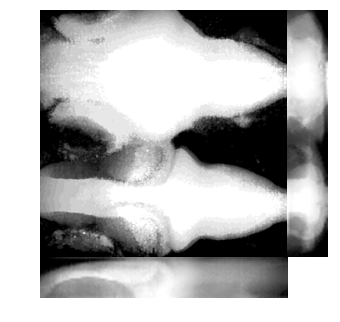

In [9]:
from skimage.morphology import dilation, disk
from fish.image.vol import proj_plot
mask = ref > 103
mask = np.array([dilation(m, selem=disk(9)) for m in mask])
proj_plot(mask, np.mean, aspect=(16,1,1));

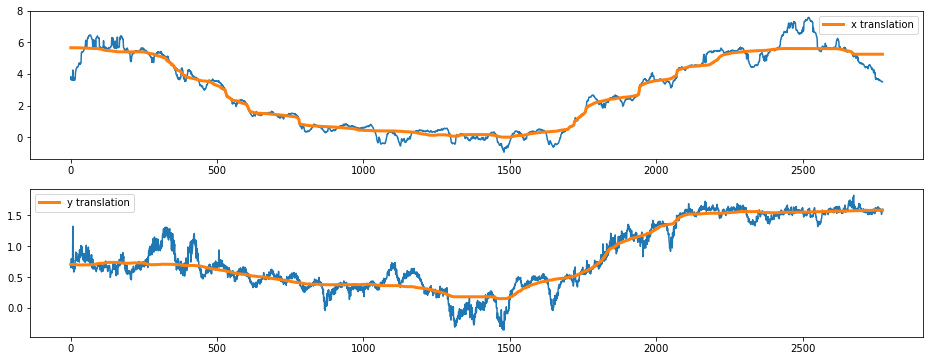

In [10]:
from scipy.ndimage.filters import median_filter
fig, axs = plt.subplots(nrows=2, figsize=(16,6))
x_trans_raw = affs[:, -2, -1]
y_trans_raw = affs[:, 0, -1]
x_trans = median_filter(x_trans_raw, size=400)
y_trans = median_filter(y_trans_raw, size=400)
z_trans = np.zeros(x_trans.shape)
trans = np.vstack([z_trans, y_trans, x_trans])

axs[0].plot(x_trans_raw)
axs[0].plot(x_trans, linewidth=3, label = 'x translation')
axs[0].legend()
axs[1].plot(y_trans_raw)
axs[1].plot(y_trans, linewidth=3, label = 'y translation')
axs[1].legend()

In [11]:
from scipy.ndimage.interpolation import shift

# important to apply -1 * translation
ims_registered = ims.map(lambda v: shift(v[1], -trans[:, v[0][0]], mode='wrap'), with_keys=True).astype('float32')

# send background pixels to 0
#ims_registered = ims_registered.map(lambda v: v * mask)

In [ ]:
# function to generate local projections 
def my_proj(v, slab_z = 4):    
    from fish.image.vol import sub_proj    
    from numpy import amin, amax
    # number of planes per projection        
    n_slabs = int(np.ceil(v.shape[0] / slab_z))    
    chopped = sub_proj(v, 0, amin, n_slabs) + sub_proj(v, 0, amax, n_slabs)
    return chopped

def rescale(v, in_range, out_range):    
    in_ptp = in_range[1] - in_range[0]
    out_ptp = out_range[1] - out_range[0]    
    rescaled = (((v - in_range[0]) * out_ptp) / in_ptp) + out_range[0]        
    return rescaled

In [ ]:
# take 300s baseline
baseline_window = int(300 / fs_im)
ds = 4
ser = ims_registered.uniform_filter(size=(1,ds,ds))[:,:,::ds,::ds].toseries()
ser = ser.normalize(method = 'window', window=baseline_window).astype('float32')
bounds = ser.map(lambda v: (v.min(), v.max())).toarray()
mn, mx = bounds.min(), bounds.max()
slabs = ser.toimages().map(lambda v: rescale(v, (mn,mx), (0,4096))).map(my_proj).astype('int16')

In [ ]:
mn, mx = bounds.min(), bounds.max()
slabs = ser_ims.map(lambda v: rescale(v, (mn,mx), (0,4096))).map(my_proj).astype('int16')

In [ ]:
def save_ims(kv, dest_dir):
    from skimage.io import imsave
    key = kv[0][0]
    val = kv[1]    
    fname = 't_{:06d}.tif'.format(key)
    imsave(dest_dir + fname, val, compress=1)

In [ ]:
%%time
slabs.tordd().foreach(lambda v: save_ims(v, dest_dir))

In [ ]:
%%bash
qdel -u bennettd
